## Setup

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya, loadMCSamples
from getdist import gaussian_mixtures
import getdist.plots as gdplt

from numpy import loadtxt, savetxt, mgrid, argwhere, c_, arange, linspace, reshape
from sympy import symbols, diff, lambdify
from itertools import combinations

import matplotlib
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

%matplotlib inline

gdplot = gdplt.get_subplot_plotter()

In [90]:
plt.rcParams.update({"text.usetex": True,"font.family": "serif"})
myColors = ['C1', 'C2', 'C4', 'C3']

### Params

In [91]:
tau_prior = 5

#slurm_id=37940610 #Good, tau prior off?
slurm_id=38004012
job = f'BBN_small_eta10'

data_file_base=f'BBN_small_0.005'
save_name=f'BBN_small_5_0.005'

#### const params

In [ ]:

gparams = ['eta10', 'N_nu', 'tau']
removeParams = []
fixedParams = {}

experiment = 0
spectrum = 'unlensed'
useDali = True
save_pdf = True
cobaya_debug = True

inc_base='/users/stevensonb/scratch/tmp/chains/incomplete'
fin_base='/users/stevensonb/Research/DALI/chains'

i = 0 if tau_prior == 0.5 else tau_prior

if os.path.exists(f'{fin_base}/complete/{job}/{slurm_id}/{i}/'):
    exact_chain_path = f'{fin_base}/complete/{job}/{slurm_id}/{i}/{i}'
elif os.path.exists(f'{inc_base}/{job}/{slurm_id}/{i}/'):
    exact_chain_path=f'{inc_base}/{job}/{slurm_id}/{i}/{i}'
else:
    print(f'Could not find chain for {job} {slurm_id} {i}')
    assert False

print(f'Loading chain from {exact_chain_path}')

## Functions

In [93]:
latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_b h^2', 
    'N_eff':r'N_\mathrm{eff}',
    'N_nu':r'N_\mathrm{eff}', # Just for the effect
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau_n\;[s]',
    'mnu':r'm_\mathrm{\nu}',
    'eta10':r'\eta_\mathrm{10}'
}

def get_data(dfile=f'{data_file_base}.pkl', fixed_params=fixedParams):
    params = {}
    with open(dfile, 'rb') as f:
        data = pickle.load(f)

    fid = data['cosmoFid']
    fisher = data['fisherGaussian'][experiment][spectrum]
    fisher[2,2] += 1/tau_prior**2
    inv = np.linalg.inv(fisher)
    
    widths = {'eta10': 3, 'N_nu': 3, 'tau': 200}

    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': max(v-widths[k],0), 'max':v+widths[k]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
            
    return params, fid, inv

def get_model(data_file=f'{data_file_base}.pkl', fixed_params=fixedParams):
    params, cosmoFid, cov = get_data(data_file, fixed_params)
    
    model = {
        'debug': cobaya_debug,
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'use_dali': True,
                'file': data_file,
                'remove': removeParams,
                'experiment': experiment,
                'spectrum': spectrum,
                'tau_prior': tau_prior
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                # 'covmat_params': list(params.keys()),
                # 'covmat': cov,
                'oversample_power': 0.8,
                'proposal_scale': 1.5,
                'Rminus1_stop': 0.05,
                'Rminus1_cl_stop': 0.2,
                'max_tries': 1000,
            }
        }
    }
    return model


### Curvature Func

In [94]:

"""
Created on Tuesday, July 26, 2022, at 01:23 PM

@author: Joe Ryan and Cynthia Trendafilova
Modifications by: Brandon Stevenson
"""
def add_KBBN(bounds, 
grid_order = list(combinations(range(0, 3), r=2)), 
plot_order = list(combinations(range(0, 3), r=2)),
contour_levels = [0, 2.3, 6.17], 
data_file = f'{data_file_base}.pkl',
lws=[1, 1, 1],
colors=myColors,
exp=experiment, 
spec=spectrum,
grid_size=16j,
linspace_size=50,
alphas=[0.5,0.5,1]
):
    """
    Note: girid_order and plot_order must be the same length
    """

    with open(f'{data_file_base}.pkl', 'rb') as f:
        data_BBN = pickle.load(f)
    
    fid = data_BBN['cosmoFid']
    F = data_BBN['fisherGaussian'][exp][spec]
    F[2,2] += 1/tau_prior**2
    G = data_BBN['DALI3Gaussian'][exp][spec]
    H = data_BBN['DALI4Gaussian'][exp][spec]
    
    x = symbols('x', real=True)
    y = symbols('y', real=True)

    p_names = list(fid.keys())
    p_fid = list(fid.values())

    for q in range(0, len(plot_order), 1):        
        i = plot_order[q][0]
        j = plot_order[q][1]
        ij = [i, j]
        
        p = [x - p_fid[i], y - p_fid[j]]
        
        sumF = (-1/2)*(F[i][i]*p[0]*p[0] + F[i][j]*p[0]*p[1] + F[j][i]*p[1]*p[0] + F[j][j]*p[1]*p[1])
        sumG = 0
        sumH = 0
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    sumG += (-1/2)*G[ij[a]][ij[b]][ij[c]]*p[a]*p[b]*p[c]
        
        for a in range(0, 2, 1):
            for b in range(0, 2, 1):
                for c in range(0, 2, 1):
                    for d in range(0, 2, 1):
                        sumH += (-1/8)*H[ij[a]][ij[b]][ij[c]][ij[d]]*p[a]*p[b]*p[c]*p[d]
                        
        Phi = -(sumF + sumG + sumH)
        
        Phi0 = diff(Phi, x)
        Phi1 = diff(Phi, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_D = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeD = argwhere(K_D <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeD)
    
        ### Sanity check:
        Phi_F = -sumF
        
        Phi0 = diff(Phi_F, x)
        Phi1 = diff(Phi_F, y)
        
        Phi00 = diff(Phi0, x)
        Phi01 = diff(Phi0, y)
        Phi11 = diff(Phi1, y)
        
        k = (Phi00*(Phi1**2) + Phi11*(Phi0**2) - 2*Phi1*Phi01*Phi0)/((Phi0**2 + Phi1**2)**(3/2))
        K = lambdify([x, y], k)
            
        x0, x1 = mgrid[bounds[i][0]:bounds[i][1]:grid_size, bounds[j][0]:bounds[j][1]:grid_size]
    
        ### pass to lambdify'd functions
        ### output is 2d array of curvatures
        K_F = K(x0, x1)
        
        ### indices of negative values in DALI
        negativeF = argwhere(K_F <= 0)
        
        ### save to output file
        # savetxt('TEST_KBBNV1_negative_zero_Fisher_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', negativeF)
        
        #if len(negativeD) != 0:
        X0 = []
        X1 = []
        
        for u in arange(0, len(negativeD), 1):
            I0 = negativeD[u][0]
            I1 = negativeD[u][1]
            
            X0.append(x0[I0][I1])
            X1.append(x1[I0][I1])
            
        ### Save coordinates:
        # savetxt('coords_KBBNV1_negative_zero_doublet_16x16_grid_exact_deriv_sympy_' + str(i) + str(j) + '_' + datalab + '.txt', c_[X0, X1])
    
        ### Plot coordinates at which K <= 0 over Fisher and Doublet cross-section contours:
       
        X = linspace(bounds[i][0], bounds[i][1], linspace_size)
        Y = linspace(bounds[j][0], bounds[j][1], linspace_size)
        
        Z = []
        Z_F = []
        xl = []
        yl = []
        
        Phi_L = lambdify([x, y], Phi)
        Phi_FL = lambdify([x, y], Phi_F)
        for xc0 in X:
            for xc1 in Y:
                Z.append(Phi_L(xc0, xc1))
                Z_F.append(Phi_FL(xc0, xc1))
                xl.append(xc0)
                yl.append(xc1)    

        x_2d = reshape(xl, (linspace_size, linspace_size))
        y_2d = reshape(yl, (linspace_size, linspace_size))
        z_2d = reshape(Z, (linspace_size, linspace_size))
        zf_2d = reshape(Z_F, (linspace_size, linspace_size))

        ax = gdplot.get_axes(grid_order[q])

        # set labels in accordance with plotter style
        lab_fontsize = gdplot._scaled_fontsize(gdplot.settings.axes_labelsize)
        ax.set_xlabel('$'+latex_trans.get(p_names[i], p_names[i])+'$',  fontsize=lab_fontsize, verticalalignment='baseline', labelpad=4 + lab_fontsize)
        ax.set_ylabel('$'+latex_trans.get(p_names[j] , p_names[j])+'$', fontsize=lab_fontsize)

        tick_label_size = gdplot._scaled_fontsize(None, gdplot.settings.axes_fontsize)
        ax.tick_params(which='major', labelsize=tick_label_size)
        # ax.get_offset_text().set_fontsize(tick_label_size * 3 / 4 if tick_label_size > 7 else tick_label_size)

        ax.set_xlim(bounds[i][0], bounds[i][1])
        ax.set_ylim(bounds[j][0], bounds[j][1])
        
        ax.scatter(X0, X1, marker='.', color=colors[3], zorder=1, label='Concavity', alpha=alphas[2])
        ax.contour(x_2d, y_2d, z_2d, contour_levels, colors=colors[1], linestyles='dashed', zorder=3, lws=20, alpha=alphas[1]).collections[0].set_label('DALI') 
        ax.contour(x_2d, y_2d, zf_2d, contour_levels, colors=colors[2], linestyles='dotted', zorder=2, lws=20, alpha=alphas[0]).collections[0].set_label('Fisher') # fisher

## Progress Report

In [95]:
from cobaya.samplers.mcmc import plot_progress

id=slurm_id

#id=37941076

chain_loc=f'{inc_base}/{job}/{id}'
# chain_loc=f'{fin_base}/complete/{job}/{slurm_id}'
# chain_loc=f'{fin_base}/failed/{job}/{slurm_id}'

for i in [0,1,5,10,15,30]:
    path = f'{chain_loc}/{i}'
    if os.path.exists(path):
        plot_progress(f'{path}/{i}')
        plt.title(f'Chain {i}')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Chain {i} does not exist at {path}')

Chain 0 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/0
Chain 1 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/1
Chain 5 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/5
Chain 10 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/10
Chain 15 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/15
Chain 30 does not exist at /users/stevensonb/scratch/tmp/chains/incomplete/BBN_small_eta10/38004012/30


## Analysis

### Generator

In [96]:
%%capture

gdsExact = loadMCSamples(exact_chain_path)
gdsExact.name_tag = 'Exact'

data = None
with open(f'{data_file_base}.pkl', 'rb') as f: 
    data = pickle.load(f)  
    
fid = data['cosmoFid']
fisher = data['fisherGaussian'][experiment][spectrum]
fisher[2,2] += (1/tau_prior**2)
inv = np.linalg.inv(fisher)

aFisher = gaussian_mixtures.GaussianND(list(fid.values()), inv, label='Fisher', names=list(fid.keys()), labels=[f'${latex_trans.get(k, k)}$' for k in fid.keys()])

updatedDali, samplerDali = run(get_model());
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='DALI');

### Solo Plotter

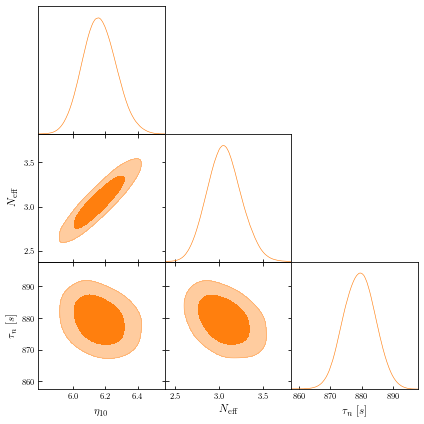

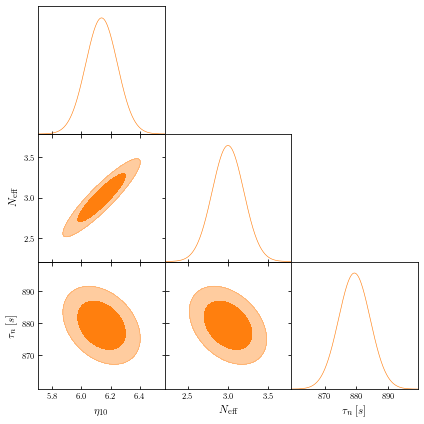

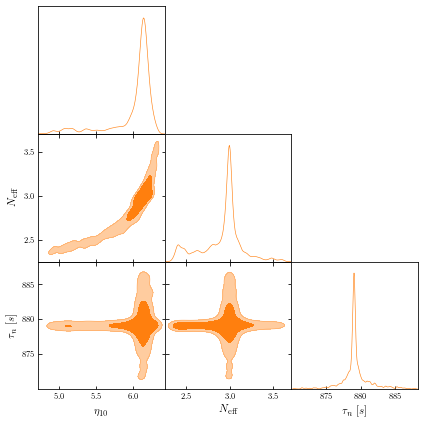

In [97]:
gdplot.triangle_plot(gdsExact, gparams, filled=True, colors=myColors, contour_colors=myColors)
# gdplot.triangle_plot(gdsFisher, params, filled=True, colors=myColors, contour_colors=myColors)

gdplot.triangle_plot(aFisher, gparams, filled=True, colors=myColors, contour_colors=myColors)

gdplot.triangle_plot(gdsDali, gparams, filled=True, colors=myColors, contour_colors=myColors)

### Finalize

<ipython-input-94-61eb3d75f5a5>:163: UserWarning: The following kwargs were not used by contour: 'lws'
  ax.contour(x_2d, y_2d, z_2d, contour_levels, colors=colors[1], linestyles='dashed', zorder=3, lws=20, alpha=alphas[1]).collections[0].set_label('DALI')
<ipython-input-94-61eb3d75f5a5>:164: UserWarning: The following kwargs were not used by contour: 'lws'
  ax.contour(x_2d, y_2d, zf_2d, contour_levels, colors=colors[2], linestyles='dotted', zorder=2, lws=20, alpha=alphas[0]).collections[0].set_label('Fisher') # fisher


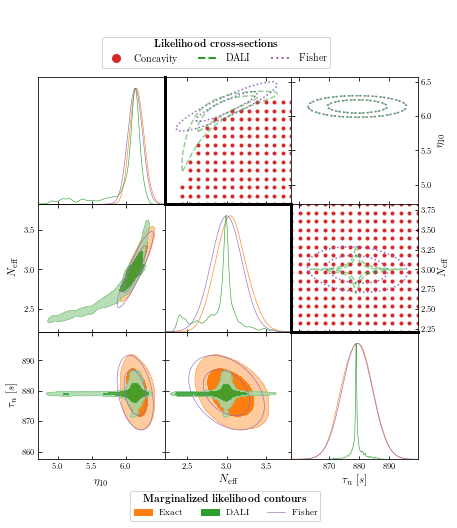

In [98]:
contour_line_widths = [2,20,20]
contour_widths = [0.6,0.6,0.6]
gdplot.settings.figure_legend_frame = True

#gdplot.triangle_plot([gdsDali, gdsDali, aFisher], gparams, filled=[True, True, False], colors=myColors, contour_colors=myColors, contour_lws=contour_line_widths, legend_ncol=3)
gdplot.triangle_plot([gdsExact, gdsDali, aFisher], gparams, figure_legend_frame=False, filled=[True, True, False], colors=myColors, contour_colors=myColors, legend_ncol=3, legend_frameon=False)

xbounds = [gdplot.get_axes((0,0)).get_xlim(), gdplot.get_axes((1,1)).get_xlim(), gdplot.get_axes((2,2)).get_xlim()]
add_KBBN(bounds=xbounds, plot_order=[[1,0], [2,0], [2,1]], contour_levels = [0, 2.3, 6.17], lws=contour_widths, alphas=[1, 0.5, 1])
###
#Clean up time
a: Axes = gdplot.get_axes((0,1))
b: Axes = gdplot.get_axes((0,2))
c: Axes = gdplot.get_axes((1,2))

# add bars to seperate the curvature from posteriors
bar_thickness = 3.0
a.spines['left'].set_linewidth(bar_thickness)
a.spines['bottom'].set_linewidth(bar_thickness)
c.spines['left'].set_linewidth(bar_thickness)
c.spines['bottom'].set_linewidth(bar_thickness)

#fix ticks and labels
a.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = False, top=True, bottom=True, left=False, right=True)
b.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=True, right=True)
c.tick_params(axis='both', direction = 'in', labeltop = False, labelbottom = False, labelleft = False, labelright = True, top=True, bottom=True, left=False, right=True)

# a.get_xaxis().set_label_position('top')
a.get_yaxis().set_label_position('right')
a.set_xlabel('')
# b.get_xaxis().set_label_position("top")
b.get_yaxis().set_label_position("right")
c.get_yaxis().set_label_position("right")
c.set_xlabel('')

#fix the tick labels
# a.set_xticks(gdplot.get_axes((1,1)).get_xticks())
# b.set_xticks(gdplot.get_axes((2,2)).get_xticks())
# c.set_xticks(gdplot.get_axes((2,2)).get_xticks())

# a.set_yticks(gdplot.get_axes((0,0)).get_xticks())
# b.set_yticks(gdplot.get_axes((0,0)).get_xticks())
# c.set_yticks(gdplot.get_axes((1,1)).get_xticks())

# legends
gdplot.legend.set_bbox_to_anchor((0.75, 0.015), transform=gdplot.fig.transFigure)
gdplot.legend.set_title(r'$\textbf{Marginalized likelihood contours}$')


legend_elements_upper = [Line2D([0], [0], marker='o', color='w', label = 'Concavity', markerfacecolor='C3', markersize = 10),
                         Line2D([0], [0], color=myColors[1], lw=2, label = 'DALI', linestyle='dashed'),
                         Line2D([0], [0], color=myColors[2], lw=2, label = 'Fisher', linestyle='dotted')]
myTitleFont = matplotlib.font_manager.FontProperties(weight='bold',size=10)
legend2 = gdplot.fig.legend(handles=legend_elements_upper, fontsize=10, ncol=3,\
             bbox_to_anchor=(0.5,1.065), loc='lower center', borderaxespad=0)
legend2.set_title(r'\textbf{Likelihood cross-sections}',prop=myTitleFont)

# Top left
# legend_2 = c.legend(ncol=2, bbox_to_anchor=(0.4, 1.1), bbox_transform=gdplot.fig.transFigure)
# Top Center
# legend2 = c.legend(ncol=3, bbox_to_anchor=(0.8, 1.065), bbox_transform=gdplot.fig.transFigure, frameon=True)
#bottom center
#legend_2 = c.legend(ncol=3, bbox_to_anchor=(0, -0.15), bbox_transform=gdplot.fig.transFigure)
# legend2.set_title(r'$\textbf{Likelihood cross-sections}$')

# fix overlapping of curvature points on some borders
for ax in [a,b,c]:
    for k, spine in ax.spines.items():
        spine.set_zorder(10)

if save_pdf:
    # export wasn't adjusting overall figure size to fit the curvature legend, so we do it manually
    # gdplot.export(job + '.pdf')
    gdplot.fig.savefig(f'{save_name}.pdf', bbox_extra_artists=gdplot.extra_artists + [legend2], bbox_inches='tight')